In [35]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

from models.macaw import MACAW

import sys

sys.path.append("..")


from utils.datasets import TorchDataset as TD
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
mode = "test"
test_block = "flat"
nlatents = 64
ncauses = 19
sex_idx = 9
PD_idx = 18

checkpoint = torch.load("checkpoints/PD-SFCN/best_model.pt")
weights = checkpoint["model_state_dict"]["classifier.fc.weight"].data.cpu().numpy()
bias = checkpoint["model_state_dict"]["classifier.fc.bias"].data.cpu().numpy()

In [37]:
model = MACAW(nlatents=nlatents).to("cuda")
checkpoint = torch.load(f"checkpoints/act-macaw-{test_block}/best_model.pt")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [38]:
ds = TD(f"/data/Data/PD/activations_{test_block}_{mode}")
data_loader = DataLoader(ds, batch_size=128, shuffle=False)

In [39]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1 - y_true) * np.log(1 - y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0 + term_1, axis=0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)


In [40]:
import numpy as np

g_dict = {"Study": np.arange(9), "Sex": [0, 1]}
cf_dict = {}


temp = {k: 0 for k in range(9)}
model.eval()

grp_mean = np.zeros((len(ds), nlatents + ncauses))
for v in range(9):
    obs = []
    cfs = []
    cf_vals = temp.copy()
    cf_vals[v] = 1
    for b in data_loader:
        x_obs, x_cf = model.counterfactuals(b.to("cuda"), cf_vals=cf_vals)
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f"Study_{v}"] = cf

cf_dict[f"Study_mean"] = grp_mean / 9

grp_mean = np.zeros((len(ds), nlatents + ncauses))
for v in [0, 1]:
    obs = []
    cfs = []
    for b in data_loader:
        x_obs, x_cf = model.counterfactuals(b.to("cuda"), cf_vals={sex_idx: v})
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f"Sex_{v}"] = cf

cf_dict[f"Sex_mean"] = grp_mean / 2


In [41]:
from sklearn.metrics import roc_curve, auc

obs_pred = sigmoid(obs[:, ncauses:] @ weights.T + bias).squeeze()
fpr, tpr, thresholds = roc_curve(obs[:, PD_idx], obs_pred)
obs_roc_auc = auc(fpr, tpr)
obs_bce = BinaryCrossEntropy(obs[:, PD_idx], obs_pred)
print(f"Obs- AUROC: {obs_roc_auc}, BCE:{obs_bce}")

df = pd.DataFrame(
    {
        "pd_true": obs[:, PD_idx],
        "obs_pred": obs_pred,
        "sex": obs[:, sex_idx],
        "study": np.argmax(obs[:, :9], axis=1),
        "scanner": np.argmax(obs[:, 10:18], axis=1),
    }
)
df

Obs- AUROC: 0.7362984218077474, BCE:0.6102814078330994


,pd_true,obs_pred,sex,study,scanner
0,1.0,0.701383,1.0,3,2
1,0.0,0.348286,1.0,1,1
2,0.0,0.422487,1.0,0,0
3,0.0,0.681636,0.0,8,7
4,0.0,0.648173,1.0,6,5
...,...,...,...,...,...
329,1.0,0.871718,1.0,4,3
330,1.0,0.470091,0.0,5,4
331,0.0,0.651817,0.0,1,1
332,1.0,0.488814,1.0,8,7


In [42]:
for k, v in g_dict.items():
    mean_pred = sigmoid(cf_dict[f"{k}_mean"][:, ncauses:] @ weights.T + bias).squeeze()
    fpr, tpr, thresholds = roc_curve(obs[:, PD_idx], mean_pred)
    obs_roc_auc = auc(fpr, tpr)
    obs_bce = BinaryCrossEntropy(obs[:, PD_idx], mean_pred)
    print(f"{k}- AUROC: {obs_roc_auc}, BCE:{obs_bce}")
    df[f"{k}_pred"] = mean_pred

Study- AUROC: 0.6549856527977045, BCE:0.6684383013995925
Sex- AUROC: 0.7361908177905309, BCE:0.6097329350261164


In [47]:
def compute_subgroup_metrics(
    df, y_true_col="pd_true", y_prob_col="pd_pred", subgroup_col="scanner"
):
    unique_scanners = df[subgroup_col].unique()

    subgroup_metrics = {}
    for subgroup in unique_scanners:
        scanner_df = df[df[subgroup_col] == subgroup]
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            subgroup_metrics[subgroup] = {
                "fpr": fpr,
                "tpr": tpr,
                "thresholds": thresholds,
                "auc": roc_auc,
                "total_samples": len(scanner_df),
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {subgroup}: {e}")

    return subgroup_metrics

In [78]:
study_obs_metrics = compute_subgroup_metrics(
    df, y_true_col="pd_true", y_prob_col="obs_pred", subgroup_col="study"
)

sex_obs_metrics = compute_subgroup_metrics(
    df, y_true_col="pd_true", y_prob_col="obs_pred", subgroup_col="sex"
)

study_cf_study_metrics = compute_subgroup_metrics(
    df, y_true_col="pd_true", y_prob_col="Study_pred", subgroup_col="study"
)

sex_cf_sex_metrics = compute_subgroup_metrics(
    df, y_true_col="pd_true", y_prob_col="Sex_pred", subgroup_col="sex"
)

In [79]:
cf_study_study_auc = {}

for a in study_obs_metrics.keys():
    cf_study_study_auc[a] = (
        study_cf_study_metrics[a]["auc"] - study_obs_metrics[a]["auc"]
    )

cf_sex_sex_auc = {}

for a in sex_obs_metrics.keys():
    cf_sex_sex_auc[a] = sex_cf_sex_metrics[a]["auc"] - sex_obs_metrics[a]["auc"]

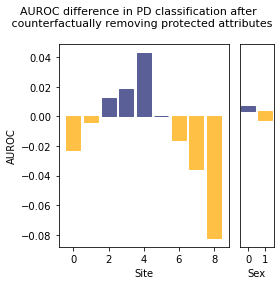

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(4, 4), gridspec_kw={"width_ratios": [5, 1]})

# Create bar plot with custom colors
bars = ax[0].bar(cf_study_study_auc.keys(), cf_study_study_auc.values())

# Color bars based on positive/negative values
for i, value in enumerate(cf_study_study_auc.values()):
    if value >= 0:
        bars[i].set_color("#5B5F97")
    else:
        bars[i].set_color("#FFC145")

# Customize the plot
fig.suptitle(
    "AUROC difference in PD classification after \n counterfactually removing protected attributes",
    fontsize=11,
)
ax[0].set(xlabel="Site", ylabel="AUROC")

bars = plt.bar(cf_sex_sex_auc.keys(), cf_sex_sex_auc.values())


# Color bars based on positive/negative values
for i, value in enumerate(cf_sex_sex_auc.values()):
    if value >= 0:
        bars[i].set_color("#5B5F97")
    else:
        bars[i].set_color("#FFC145")

# Customize the plot
ax[1].set(xlabel="Sex", ylim=[-0.08, 0.04], xticks=[0, 1], yticks=[])

# Show the plot
plt.tight_layout()
plt.savefig(f"/data/Papers/MICCAI-biases/macaw-analysis/cf_diff.pdf", dpi=300)
plt.show()

In [84]:
study_obs_metrics

{3: {'fpr': array([0.  , 0.25, 0.25, 0.5 , 0.5 , 0.75, 0.75, 1.  , 1.  ]),
  'tpr': array([0.        , 0.        , 0.14814815, 0.14814815, 0.62962963,
         0.62962963, 0.77777778, 0.77777778, 1.        ]),
  'thresholds': array([1.8852546 , 0.8852547 , 0.7588297 , 0.7522411 , 0.6217069 ,
         0.60135275, 0.54978925, 0.54217863, 0.30881652], dtype=float32),
  'auc': 0.3888888888888889,
  'total_samples': 31},
 1: {'fpr': array([0.        , 0.        , 0.01265823, 0.01265823, 0.02531646,
         0.02531646, 0.05063291, 0.05063291, 0.07594937, 0.07594937,
         0.12658228, 0.12658228, 0.17721519, 0.17721519, 0.20253165,
         0.20253165, 0.25316456, 0.25316456, 0.27848101, 0.27848101,
         0.30379747, 0.30379747, 0.36708861, 0.36708861, 0.40506329,
         0.40506329, 0.4556962 , 0.4556962 , 0.46835443, 0.46835443,
         0.62025316, 0.62025316, 0.69620253, 0.69620253, 0.89873418,
         0.89873418, 0.92405063, 0.92405063, 1.        ]),
  'tpr': array([0.        , 

In [86]:
study_cf_study_metrics["auc"], study_obs_metrics["auc"]

KeyError: 'auc'